In [25]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
import joblib
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

In [52]:
# ───────────────────────────────────────────────────────────────────────────────
# 0. Configuration & File Paths
# ───────────────────────────────────────────────────────────────────────────────
DL_SHP       = "Te_ppm_DL_S_SOWETO.shp"
ORIG_SHP     = "Te_ppm_Orig_S_SOWETO.shp"
DL_PARQ      = "Te_ppm_DL_S_SOWETO.parquet"
ORIG_PARQ    = "Te_ppm_Orig_S_SOWETO.parquet"
TREE_DL_JOB  = "dl_tree.joblib"
TREE_ORIG_JOB= "orig_tree.joblib"
GRID_ZARR    = "perc_diff_grid.zarr"

# Target projected CRS for metre-based distances (e.g. UTM 35S)
TARGET_CRS = "EPSG:32735"

# Grid resolution in metres
GRID_SPACING = 100

In [53]:
# ───────────────────────────────────────────────────────────────────────────────
# 1. Parquet Conversion (one-time)
# ───────────────────────────────────────────────────────────────────────────────
def ensure_parquet(shp_fp, parq_fp):
    if not os.path.exists(parq_fp):
        print(f"Converting {os.path.basename(shp_fp)} → Parquet…")
        gdf = gpd.read_file(shp_fp)
        gdf.to_parquet(parq_fp, index=False)

for shp, parq in [(DL_SHP, DL_PARQ), (ORIG_SHP, ORIG_PARQ)]:
    ensure_parquet(shp, parq)

Converting Te_ppm_DL_S_SOWETO.shp → Parquet…
Converting Te_ppm_Orig_S_SOWETO.shp → Parquet…


In [54]:
# ───────────────────────────────────────────────────────────────────────────────
# 2. Load & Filter
# ───────────────────────────────────────────────────────────────────────────────
def load_gdf(parq_fp):
    gdf = gpd.read_parquet(parq_fp)         # fast columnar read
    gdf = gdf[gdf['Te_ppm'] > 0]             # drop non-positive
    return gdf.to_crs(TARGET_CRS)           # project to metres

dl_gdf   = load_gdf(DL_PARQ)
orig_gdf = load_gdf(ORIG_PARQ)

── Extended Tellurium Statistics ──
          count    mean   median  std_dev  variance  min  25%    75%    IQR    \
DL        1381433  0.753  0.069    6.320     39.941  0.0  0.048  0.136  0.088   
Original    78727  7.190  0.090   51.645   2667.204  0.0  0.040  0.200  0.160   

          max       skewness  kurtosis  cv     
DL        1079.446  28.432    2006.655  8.390  
Original  5000.000  33.453    2446.076  7.183  


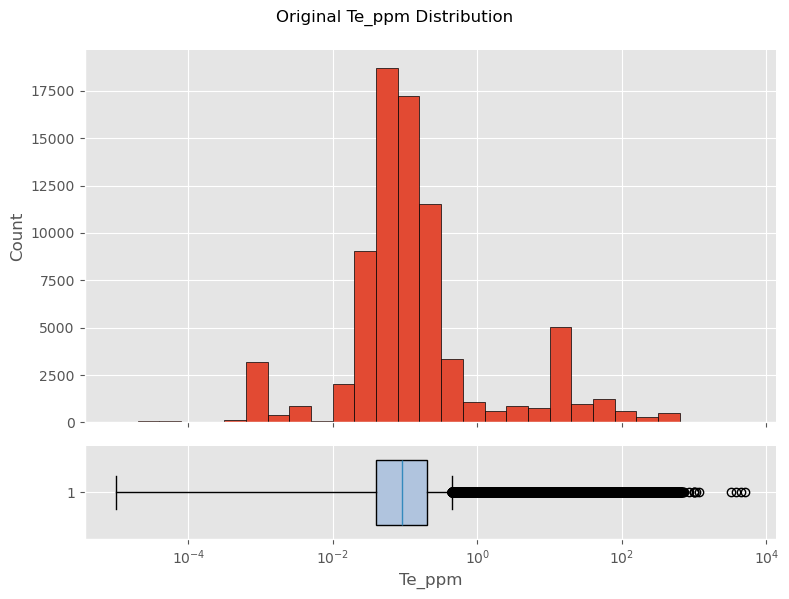

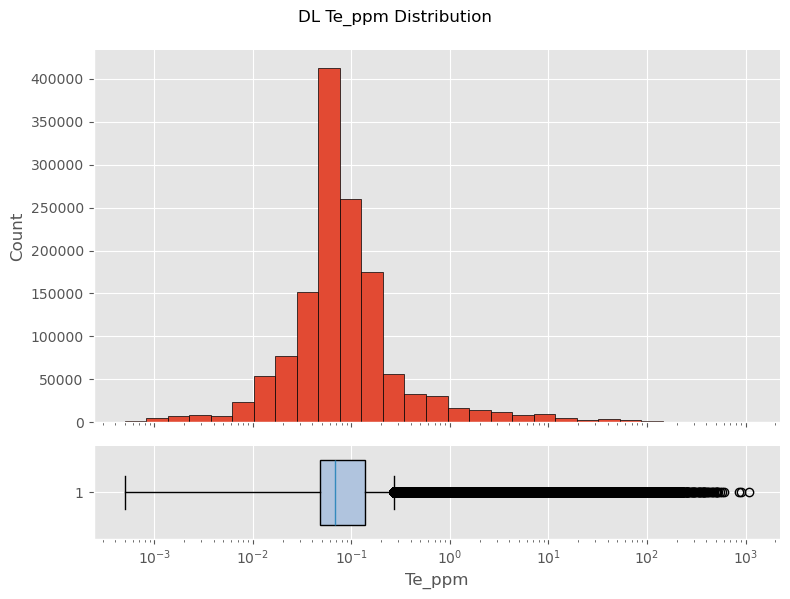

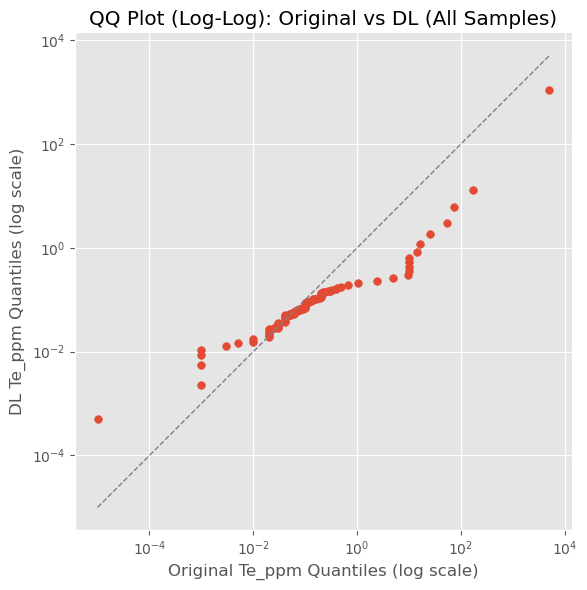

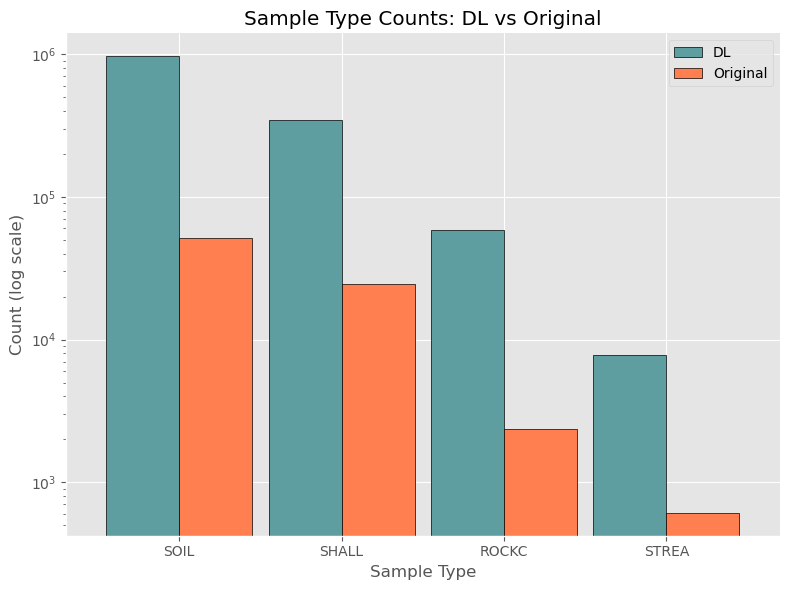

In [55]:
# ───────────────────────────────────────────────────────────────────────────────
# 3. Extended Statistics & EDA
# ───────────────────────────────────────────────────────────────────────────────
def compute_stats(te_series):
    return {
        'count':    te_series.count(),
        'mean':     te_series.mean(),
        'median':   te_series.median(),
        'std_dev':  te_series.std(),
        'variance': te_series.var(),
        'min':      te_series.min(),
        '25%':      te_series.quantile(0.25),
        '75%':      te_series.quantile(0.75),
        'IQR':      te_series.quantile(0.75) - te_series.quantile(0.25),
        'max':      te_series.max(),
        'skewness': te_series.skew(),
        'kurtosis': te_series.kurtosis(),
        'cv':   te_series.std() / te_series.mean()
    }

# Build stats table
dl_stats   = compute_stats(dl_gdf['Te_ppm'])
orig_stats = compute_stats(orig_gdf['Te_ppm'])
stats_df   = pd.DataFrame([dl_stats, orig_stats], index=['DL', 'Original']).round(3)
print("── Extended Tellurium Statistics ──")
print(stats_df)

# Plot style
plt.style.use('ggplot')

# 3a. Log-scale histogram + boxplot
def plot_dist(gdf, label):
    te = gdf['Te_ppm']
    bins = np.logspace(np.log10(te.min()), np.log10(te.max()), 30)
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                                   gridspec_kw={'height_ratios':[4,1]},
                                   figsize=(8,6))
    fig.suptitle(f"{label} Te_ppm Distribution", y=0.99)
    ax1.hist(te, bins=bins, edgecolor='black')
    ax1.set_xscale('log'); ax1.set_ylabel('Count')
    ax2.boxplot(te, vert=False, widths=0.7, patch_artist=True,
                boxprops=dict(facecolor='lightsteelblue'))
    ax2.set_xscale('log'); ax2.set_xlabel('Te_ppm')
    for ax in (ax1, ax2):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_dist(orig_gdf, "Original")
plot_dist(dl_gdf,   "DL")

# 3b. QQ-plot of Overall DL vs Original on Log-Log Scale
orig_vals = orig_gdf['Te_ppm'].values
dl_vals   = dl_gdf['Te_ppm'].values
n_q       = min(len(orig_vals), len(dl_vals), 100)
quantiles = np.linspace(0, 100, n_q)
q_orig    = np.percentile(orig_vals, quantiles)
q_dl      = np.percentile(dl_vals,   quantiles)

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(q_orig, q_dl, s=30)
m, M = min(q_orig.min(), q_dl.min()), max(q_orig.max(), q_dl.max())
ax.plot([m, M], [m, M], '--', color='grey', linewidth=1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('QQ Plot (Log-Log): Original vs DL (All Samples)')
ax.set_xlabel('Original Te_ppm Quantiles (log scale)')
ax.set_ylabel('DL Te_ppm Quantiles (log scale)')
ax.set_aspect('equal')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

# 3c. Sample-type counts
# Compute counts
counts = pd.DataFrame({
    'DL':       dl_gdf['SAMPLETYPE'].value_counts(),
    'Original': orig_gdf['SAMPLETYPE'].value_counts()
}).fillna(0)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
counts.plot(
    kind='bar',
    ax=ax,
    color=['cadetblue', 'coral'],
    edgecolor='black',
    width=0.9
)

ax.set_yscale('log')
ax.set_title('Sample Type Counts: DL vs Original')
ax.set_xlabel('Sample Type')
ax.set_ylabel('Count (log scale)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=0)
plt.legend(title='')
plt.tight_layout()
plt.show()


In [56]:
# ───────────────────────────────────────────────────────────────────────────────
# 4. KD-Tree Caching
# ───────────────────────────────────────────────────────────────────────────────
def get_tree(gdf, cache_fp):
    if os.path.exists(cache_fp):
        return joblib.load(cache_fp)
    pts = np.vstack((gdf.geometry.x, gdf.geometry.y)).T
    tree = cKDTree(pts)
    joblib.dump(tree, cache_fp)
    return tree

dl_tree   = get_tree(dl_gdf,   TREE_DL_JOB)
orig_tree = get_tree(orig_gdf, TREE_ORIG_JOB)

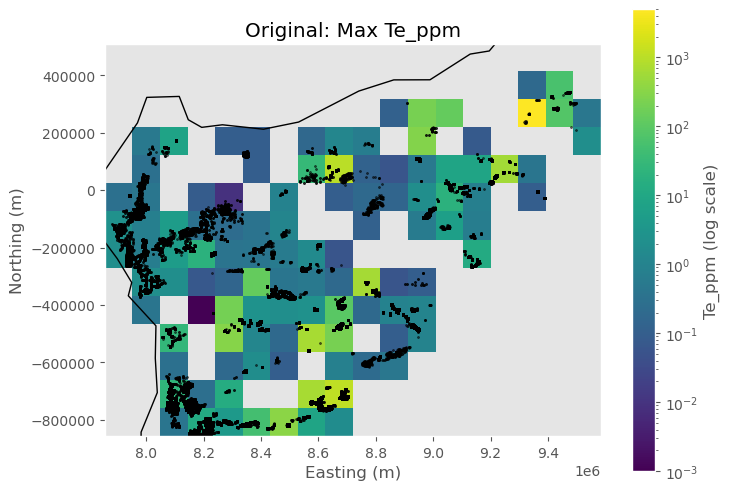

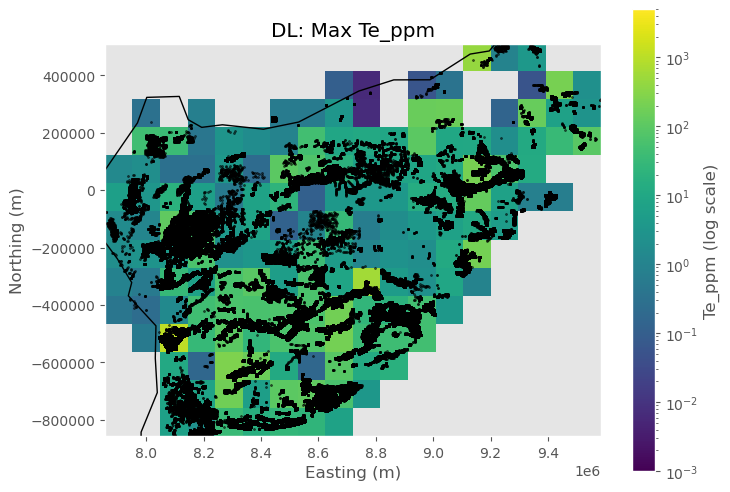

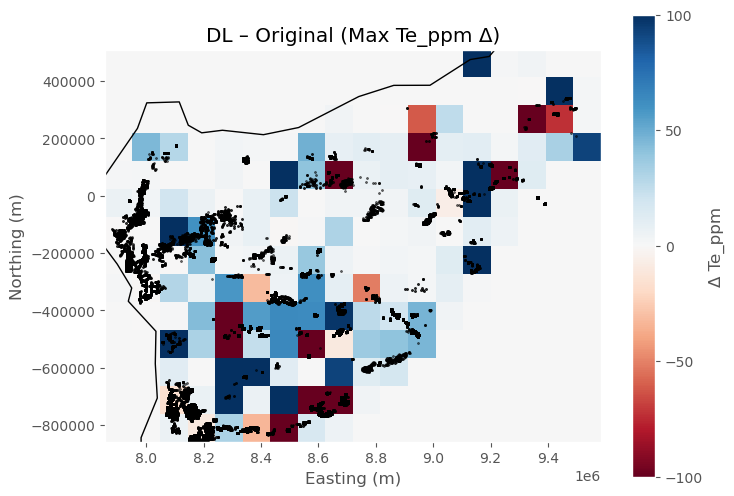

In [114]:
# ───────────────────────────────────────────────────────────────────────────────
# 5. Build & Display Raster Maps Sequentially (1) Original, (2) DL, (3) DL–Original Δ
#    with Australia outline
# ───────────────────────────────────────────────────────────────────────────────
from scipy.stats import binned_statistic_2d
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import geopandas as gpd

# 5.1 Compute grid dimensions and extent
spacing   = 100000   # 100km cells
minx1, miny1, maxx1, maxy1 = dl_gdf.total_bounds
minx2, miny2, maxx2, maxy2 = orig_gdf.total_bounds
minx, miny = min(minx1, minx2), min(miny1, miny2)
maxx, maxy = max(maxx1, maxx2), max(maxy1, maxy2)
nx = int(np.ceil((maxx - minx)/spacing))
ny = int(np.ceil((maxy - miny)/spacing))
extent = [minx, maxx, miny, maxy]

# 5.2 Rasterise max Te_ppm for original and DL
o_raw, x_edges, y_edges, _ = binned_statistic_2d(
    orig_gdf.geometry.x, orig_gdf.geometry.y, orig_gdf['Te_ppm'],
    statistic='max', bins=[nx, ny],
    range=[[minx, maxx], [miny, maxy]]
)
d_raw, _, _, _ = binned_statistic_2d(
    dl_gdf.geometry.x,   dl_gdf.geometry.y,   dl_gdf['Te_ppm'],
    statistic='max', bins=[nx, ny],
    range=[[minx, maxx], [miny, maxy]]
)
stat_orig_max = np.nan_to_num(o_raw.T, nan=0.0)
stat_dl_max   = np.nan_to_num(d_raw.T, nan=0.0)
diff = stat_dl_max - stat_orig_max

# 5.3 Define colour scales
all_vals = np.concatenate([
    stat_orig_max[stat_orig_max>0].ravel(),
    stat_dl_max[  stat_dl_max  >0].ravel()
])
log_norm  = LogNorm(vmin=all_vals.min(), vmax=all_vals.max())
diff_norm = plt.Normalize(vmin=-100, vmax=100)

# 5.4 Load Australia boundary
countries = gpd.read_file("ne_110m_admin_0_countries.shp")
australia = countries[countries['ADMIN']=="Australia"].to_crs(orig_gdf.crs)

# 5a. Original: Max Te_ppm
fig, ax = plt.subplots(figsize=(8,6))
masked_o = np.ma.masked_where(stat_orig_max<=0, stat_orig_max)
im = ax.imshow(
    masked_o,
    origin='lower',
    extent=extent,
    cmap='viridis',
    norm=log_norm
)
ax.scatter(orig_gdf.geometry.x, orig_gdf.geometry.y, c='k', s=2, alpha=0.6)
australia.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_title("Original: Max Te_ppm")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.grid(False)
fig.colorbar(im, ax=ax, label='Te_ppm (log scale)')
plt.show()

# 5b. DL: Max Te_ppm
fig, ax = plt.subplots(figsize=(8,6))
masked_d = np.ma.masked_where(stat_dl_max<=0, stat_dl_max)
im = ax.imshow(
    masked_d,
    origin='lower',
    extent=extent,
    cmap='viridis',
    norm=log_norm
)
ax.scatter(dl_gdf.geometry.x, dl_gdf.geometry.y, c='k', s=2, alpha=0.6)
australia.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_title("DL: Max Te_ppm")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.grid(False)
fig.colorbar(im, ax=ax, label='Te_ppm (log scale)')
plt.show()

# 5c. Difference: DL – Original Δ
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(
    diff,
    origin='lower',
    extent=extent,
    cmap='RdBu',
    norm=diff_norm
)
ax.scatter(orig_gdf.geometry.x, orig_gdf.geometry.y, c='k', s=2, alpha=0.6)
australia.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_aspect('equal')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
ax.set_title("DL – Original (Max Te_ppm Δ)")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.grid(False)
fig.colorbar(im, ax=ax, label='Δ Te_ppm', ticks=[-100, -50, 0, 50, 100])
plt.show()
